<a href="https://colab.research.google.com/github/SamLutz/2024_MLEES/blob/main/Labs/10_hybird_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## (Exercise) Introduction to Hybrid Models: Combining Physics-Based and Machine Learning Models

### Learning Objectives:
1. **Model glaciers using physics-based approaches**.
2. **Understand hybrid models** and how they integrate physics-based and ML methods.
3. **Explore the advantages and limitations** of hybrid models.
4. **Examine applications** of combining ML and physical models.



**Q: What is a glacier from your perspective?**



<center>
<img src="https://i0.wp.com/lenews.ch/wp-content/uploads/2017/12/Aletsch-glacier_%C2%A9-Reinhardt-_-Dreamstime.jpg?w=800&ssl=1" alt="Aletsch Glacier Switzerland" width=80%></img>
</center>
<figcaption>Figure 1: Aletsch Glacier in Switzerland. Source: Le News (2017).</figcaption>


<br> <i> **A modeler's perspective:** A glacier is a non-Newtonian fluid with stress-dependent viscosity, flowing from higher to lower elevations. </i>
</center>


#### Introduction to Glacier Flow

Glaciers are massive bodies of ice that flow slowly under their own weight. The flow of ice in a glacier is a complex process governed by physical laws that describe how the ice deforms and moves.

Given an initial glacier geometry, the time evolution of ice thickness $h(x, y, t)$ is determined by the mass conservation equation, which couples ice dynamics and surface mass balance (SMB) through:

\begin{equation}
\frac{\partial h}{\partial t} + \nabla \cdot (\mathbf{u}h) = \text{SMB},
\end{equation}

where $\nabla \cdot$ denotes the divergence operator with respect to the flux ($Q = \mathbf{u}h$). $\mathbf{u}$ is the vertically averaged horizontal ice velocity field, and SMB is the surface mass balance function, representing the integration of ice accumulation and ablation over one year.

The mass conservation equation is generic and can be applied to model glacier evolution in various applications, provided adequate SMB and ice-flow model components are available.

In the following, we primarily focus on developing an efficient numerical method to compute ice flow, as it is often the most computationally expensive component of glacier evolution models:

- First, we will use a numerical solution to compute $Q$.
- Then, we will employ a data-driven (ML) approach to emulate ice flow.

Although state-of-the-art ML techniques, such as Physics-Informed Neural Networks (PINNs), are widely used, they typically do not conserve ice thickness to machine precision. To address this limitation, this chapter focuses on hybrid models that explicitly integrate the mass conservation equation while leveraging ML for the computationally intensive modeling of ice flow.

#### Numerical Solution for **u**

We can describe the ice-flow equations under stress, but their computational cost makes them impractical for large-scale ice-sheet modeling over long time periods. This leads us to introduce the **shallow ice approximation (SIA)**, which is used in ice sheet models due to its simplicity and efficiency.

The SIA simplifies the full Stokes equations by assuming that the ice flow is dominated by vertical shear stresses and that horizontal stresses can be neglected. This results in an expression for the ice velocity in terms of the ice thickness gradient and the surface slope. The ice velocity $\mathbf{u}[m/a]$ can be approximated as:

\begin{equation}
\mathbf{u} = -\left(\frac{2 A}{n+2}\right) \left(\rho g \sin(s)\right)^n h^{n+1} \nabla h.
\end{equation}




This equation governs the horizontal velocity of ice based on the local ice thickness and slope. Substituting $\mathbf{u}$ into the mass conservation equation, we obtain:

\begin{equation}
\frac{\partial h}{\partial t} + \nabla \cdot \left(D(h,z)\frac{\partial z}{\partial x}\right) = \text{SMB},
\end{equation}

where

\begin{equation}
D(h,z) = f_d (\rho g)^3 h^5 |\nabla S|^2.
\end{equation}

| **Parameters**                            | **Values**                  |
|-------------------------------------------|-----------------------------|
| ice velocity $\mathbf{u}$        | $m/a$                     |
| physical constant $ f_d $                | $ 1 \times 10^{-15} [Pa^{-3} yr^{-1}]$ |
| ice thickness    $h$        | m                       |
| ice density $ \rho_{\mathrm{ice}} $ ($\rho$) | 910 $kg/m^{3}$             |
| gravitational constant $ g $              | 9.81 $m s^{-2}$             |
| Glen's flow rate factor $ A $             | MPa^{−3}a^{−1}       |
| Glen's law exponent $ n $                 | 3                           |
| surface slope $ s $                       | gradient       |

Note that $Pa =Kg/(m⋅s^2)$


This equation describes the time evolution of the ice thickness, where the velocity $\mathbf{u}$ is computed from the ice sheet's surface slope and thickness. This approach provides a balance between accuracy and computational efficiency and is widely used in large-scale ice sheet models.



##### Boundary Conditions with No-Slip Condition at the Base

In many glacier models, we assume a no-slip condition at the base, meaning the ice velocity is zero at the bedrock. This condition is suitable for glaciers that are frozen to their beds:

\begin{equation}
\mathbf{u} = 0 \quad \text{on the bedrock surface}.
\end{equation}

**Stress-Free Surface**

At the glacier surface, which is exposed to air, a stress-free boundary condition is typically applied:

\begin{equation}
\sigma \cdot \mathbf{n} = 0 \quad \text{on the surface},
\end{equation}

where $\mathbf{n}$ is the outward normal vector at the glacier surface.


In [ ]:
!pip install netcdf4
#import the necessary libraies
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import netCDF4 # This may require "!pip install netcdf4 if uninstalled"
from IPython.display import clear_output
import pooch

import xarray as xr
import tensorflow as tf
from tensorflow.keras.models import load_model
!pip install gdown --quiet


# Make True if you want to train the model from scratch. It should take 30 min to train.
train_mode=False

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00


In [ ]:
# Physical parameters
Lx = 49700    # Domain length in x (m)
Ly = 32300    # Domain length in y (m)
ttot = 700   # Time limit (yr)
grad_b = 0.001 # Mass balance gradient (no unit)
b_max = 0.5   # Maximum precip (m/yr)
Z_ELA = 3000  # Elevation of equilibrium line altitude (m)
rho = 910.0   # Ice density (g/m^3)
g   = 9.81    # Earth's gravity (m/s^2)
fd  = 1e-18   # Deformation constant (Pa^-3 y^-1)



# Initialization & load data

nout = 50       # Frequency of plotting
dtmax = 1       # maximum time step
dt = dtmax      # Initial time step
dx = 100
dy = 100        # Cell size in y
nx=int(Lx/dx)
ny=int(Ly/dy)
x = np.linspace(0, Lx, nx)  # x-coordinates
y = np.linspace(0, Ly, ny)  # y-coordinates


bedrock_url='https://unils-my.sharepoint.com/:u:/g/personal/kejdi_lleshi_unil_ch/EXI_z9iu_MlMn_J4IdG97DkBpvE8K-IKiZUxuEogU-cwVg?download=1'
hash = None
file = pooch.retrieve(bedrock_url, known_hash=hash)
nc_file = netCDF4.Dataset(file)  # Load the NetCDF file
Z_topo = nc_file.variables['topg']    # Replace 'topg' with the appropriate v

H_ice = np.zeros((ny, nx))  # Initial ice thickness
Z_surf = Z_topo + H_ice  # Initial ice surface
time = 0  # Initial time
it = 0

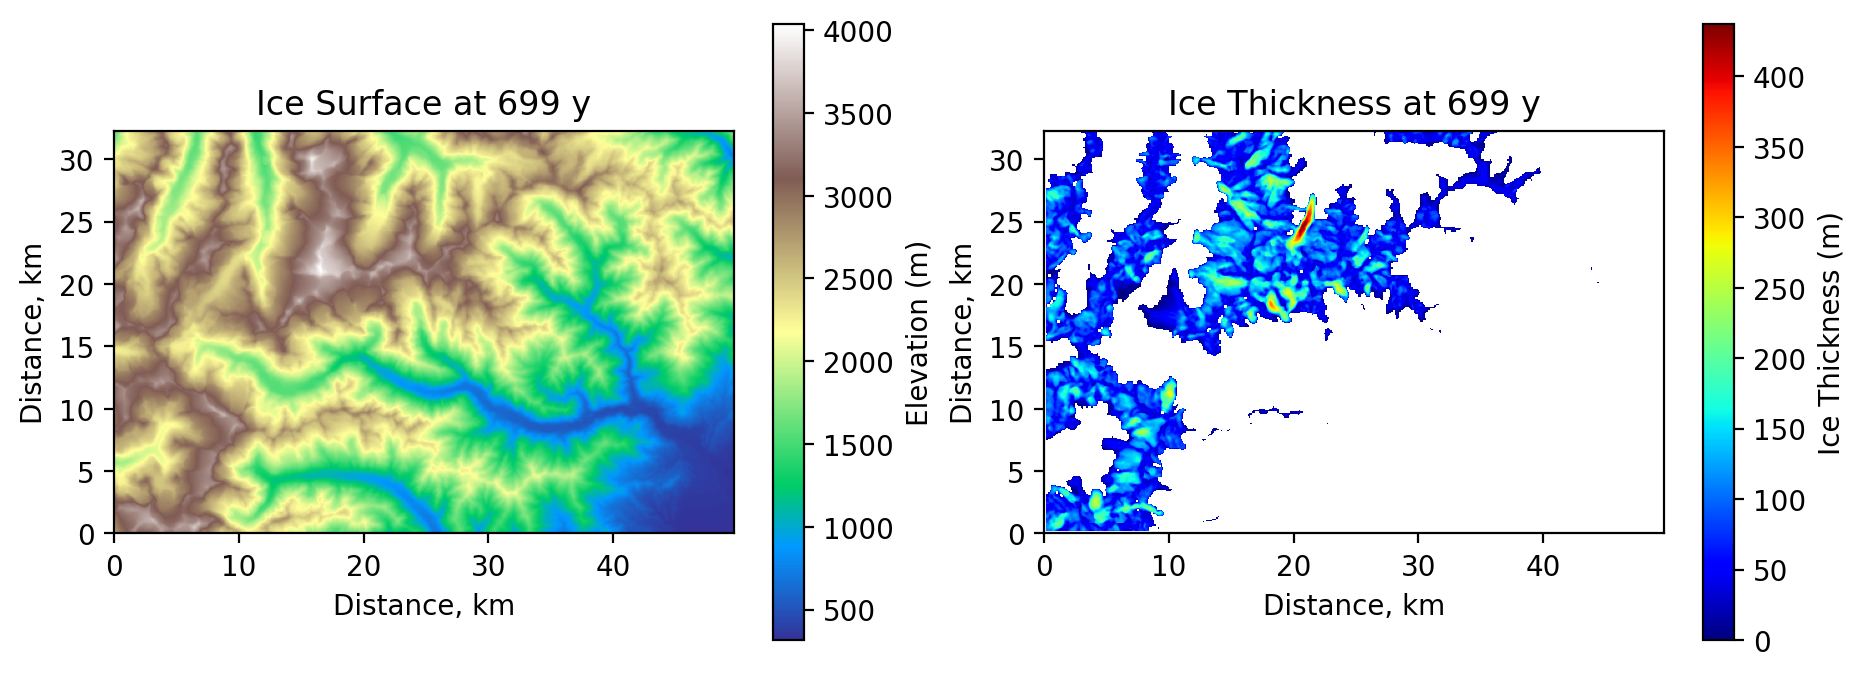

In [ ]:
# Loop
while time < ttot:

    # Update time
    time += dt
    it   += 1

    # Calculate H_avg, size (ny-1,nx-1)
    H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

    # Compute Snorm, size (ny-1,nx-1)
    Sx = np.diff(Z_surf, axis=1) / dx
    Sy = np.diff(Z_surf, axis=0) / dy
    Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
    Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
    Snorm = np.sqrt(Sx**2 + Sy**2)

    # Compute D, size (ny-1,nx-1)
    # Hint: Use `H_avg` in order to have the right dimensions for D
    D = fd * (rho*g)**3.0 * H_avg**5 * Snorm**2

    # Compute dt
    dt = min(min(dx, dy)**2 / (4.1 * np.max(D)), dtmax)

    # Compute qx, size (ny-2,nx-1)
    qx = -(0.5 * (D[:-1,:] + D[1:,:])) * np.diff(Z_surf[1:-1,:], axis=1) / dx

    # Compute qy, size (ny-1,nx-2)
    qy = -(0.5 * (D[:,:-1] + D[:,1:])) * np.diff(Z_surf[:,1:-1,], axis=0) / dy

    # Update rule (diffusion)
    dHdt = -(np.diff(qx, axis=1) / dx + np.diff(qy, axis=0) / dy)

    H_ice[1:-1, 1:-1] += dt * dHdt # size (ny-2,nx-2)

    b = np.minimum(grad_b * (Z_surf - Z_ELA), b_max)

    # Update rule (mass balance)
    H_ice[1:-1, 1:-1] += dt * b[1:-1, 1:-1]

    # Update rule (positive thickness)
    H_ice = np.maximum(H_ice, 0)

    # updatesurface topography
    Z_surf = Z_topo + H_ice

    # Update ELA after 500 years
    if time > 500:
        Z_ELA = 2700

    # Display
    if it % nout == 0:
        clear_output(wait=True)  # Clear the previous output in the notebook

        plt.figure(2, figsize=(11, 4), dpi=200)

        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf, extent=[0, Lx/1000, 0, Ly/1000], cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')

        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice > 0, H_ice, np.nan), extent=[0, Lx/1000, 0, Ly/1000], cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')

        # Show the plot
        plt.show()


⚠️ *Note: The previous code snippet took a while to execute, confirming the computational cost of traditional numerical models.*

**Q: Which is the most expensive part of solving the mass conservation equation?**  
<i>The most expensive part is the calculation of **u/D**.</i>  



### Introduction to Hybrid Modeling

Hybrid models combine traditional physics-based models (model-based, MB) with machine learning (ML) to leverage the strengths of both approaches. In purely physics-based models, system dynamics are governed by known equations, but these models often require detailed domain knowledge and can be limited by the availability of precise parameters. Machine learning, by contrast, can model complex systems without relying on such parameters, making it particularly useful for data-rich but theory-poor domains. However, ML models may struggle to generalize beyond the data they are trained on and can sometimes produce results that violate known physical laws.

**Q: How can hybrid models overcome these limitations?**  

<i>Hybrid modeling addresses these limitations by incorporating physics-informed constraints, embedding known physical equations into machine learning models, or combining the outputs of both approaches. The goal is to create models that are more accurate and robust, particularly in cases with limited data or imperfect physical models. By fusing physics with data-driven methods, hybrid models can handle sparse datasets, correct ML predictions that violate physical laws, and produce interpretable results across a wide range of applications.</i>

**Q: How can we make our simulations run faster?**  
<i>We can replace the calculation of **u** with an emulator. The emulator takes as input the state of the medium (glacier thickness, slope of the glacier, etc.) and calculates the velocity field (**u**) for the corresponding time step.</i>

#### Emulating Ice Flow with Machine Learning

The *Instructed Glacier Model* ([IGM](https://github.com/jouvetg/igm)) uses a convolutional neural network (CNN) to predict ice flow, trained on data from traditional models such as hybrid SIA+SSA or Stokes models. This approach replaces the computationally expensive ice flow component with a significantly faster emulator, enabling simulations that are up to 1000 times faster while maintaining over 90% fidelity.

##### Overview of the Machine Learning Approach

A simple version of the IGM can be built using the following steps:

1. **Input Variables**: The ML model takes ice thickness and surface slope gradients as inputs:  
   \begin{equation}
   \left\{ h(x,y), \frac{\partial s}{\partial x}, \frac{\partial s}{\partial y} \right\}.
   \end{equation}
2. **Training**: A convolutional neural network (CNN) is trained on a dataset generated from high-order glacier flow models.
3. **Prediction**: Once trained, the emulator predicts the vertically averaged ice flow components u and v based on the input variables.

The input and output fields are 2D grid rasters:

\begin{equation}
\mathbb{R}^{N_x \times N_y \times 3} \rightarrow \mathbb{R}^{N_x \times N_y \times 2}.
\end{equation}


**Q: What is another advantage of the hybrid model (besides making faster models)?**  
<i>Hybrid models can be beneficial in theory-poor domains where we do not know the equations governing system dynamics. However, sufficient data is required, and care must be taken to ensure the model is generalizable. A potential pitfall, when there is insufficient data or a lack of caution, is overfitting.</i>

##### Helper Functions You Do Not Need to Know

These functions are auxiliary tools used in the notebook to handle common tasks like loading data, scaling fields, augmenting data, and visualizing results. They simplify the workflow but are not the focus of this exercise.

In [ ]:
#@title Helper functions

# Function to load NetCDF files

def load_from_pooch(file):
    nc_file = xr.open_dataset(file)
    return nc_file


# Function to scale the field based on 90th percentile of its maximum
def scale_field(field):
    max_90th_percentile = np.percentile(field.max(axis=(1, 2)), 90)
    return field / max_90th_percentile

# Function to augment the data by flipping and adding noise
def augment_data(inputs, outputs):
    aug_inputs, aug_outputs = [], []

    for inp, out in zip(inputs, outputs):
        # Original data
        aug_inputs.append(inp)
        aug_outputs.append(out)

        # Horizontal flip
        aug_inputs.append(np.flip(inp, axis=2))  # Flip along x-axis
        aug_outputs.append(np.flip(out, axis=2))

        # Vertical flip
        aug_inputs.append(np.flip(inp, axis=1))  # Flip along y-axis
        aug_outputs.append(np.flip(out, axis=1))

    return np.array(aug_inputs), np.array(aug_outputs)

# Plot input and output fields side by side with color bars
def plot_input_output(thk, slopesurx, slopesury, ubar, vbar):
    fig, axs = plt.subplots(2, 3, figsize=(12, 5))

    # Plot inputs
    im0 = axs[0, 0].imshow(thk, cmap='Blues')
    axs[0, 0].set_title('Ice Thickness (thk)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('y')
    fig.colorbar(im0, ax=axs[0, 0], orientation='vertical')

    im1 = axs[0, 1].imshow(slopesurx, cmap='RdBu')
    axs[0, 1].set_title('Surface Slope x (slopesurx)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('y')
    fig.colorbar(im1, ax=axs[0, 1], orientation='vertical')

    im2 = axs[0, 2].imshow(slopesury, cmap='RdBu')
    axs[0, 2].set_title('Surface Slope y (slopesury)')
    axs[0, 2].set_xlabel('x')
    axs[0, 2].set_ylabel('y')
    fig.colorbar(im2, ax=axs[0, 2], orientation='vertical')

    # Plot outputs
    im3 = axs[1, 0].imshow(ubar, cmap='viridis')
    axs[1, 0].set_title('Velocity x (ubar)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('y')
    fig.colorbar(im3, ax=axs[1, 0], orientation='vertical')

    im4 = axs[1, 1].imshow(vbar, cmap='viridis')
    axs[1, 1].set_title('Velocity y (vbar)')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('y')
    fig.colorbar(im4, ax=axs[1, 1], orientation='vertical')

    # Adjust layout
    plt.tight_layout()
    plt.show()

def plot_comparison(thk, slopesurx, slopesury, true_ubar, true_vbar, pred_ubar, pred_vbar, time_idx=0):
    fig, axs = plt.subplots(3, 3, figsize=(12, 7))

    # Plot inputs with individual color bars
    im = axs[0, 0].imshow(thk[time_idx, :, :], cmap='Blues')
    axs[0, 0].set_title('Ice Thickness (thk)')
    axs[0, 0].set_xlabel('x')
    axs[0, 0].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 0])

    im = axs[0, 1].imshow(slopesurx[time_idx, :, :], cmap='RdBu')
    axs[0, 1].set_title('Surface Slope x (slopesurx)')
    axs[0, 1].set_xlabel('x')
    axs[0, 1].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 1])

    im = axs[0, 2].imshow(slopesury[time_idx, :, :], cmap='RdBu')
    axs[0, 2].set_title('Surface Slope y (slopesury)')
    axs[0, 2].set_xlabel('x')
    axs[0, 2].set_ylabel('y')
    fig.colorbar(im, ax=axs[0, 2])

    # Determine the shared vmin and vmax for velocity comparisons
    vmin_ubar = min(true_ubar.min(), pred_ubar.min())
    vmax_ubar = max(true_ubar.max(), pred_ubar.max())
    vmin_vbar = min(true_vbar.min(), pred_vbar.min())
    vmax_vbar = max(true_vbar.max(), pred_vbar.max())

    # Plot true outputs with shared color bars
    im_ubar_true = axs[1, 0].imshow(true_ubar[time_idx, :, :], cmap='viridis', vmin=vmin_ubar, vmax=vmax_ubar)
    axs[1, 0].set_title('True Velocity x (ubar)')
    axs[1, 0].set_xlabel('x')
    axs[1, 0].set_ylabel('y')
    fig.colorbar(im_ubar_true, ax=axs[1, 0])

    im_vbar_true = axs[2, 0].imshow(true_vbar[time_idx, :, :], cmap='viridis', vmin=vmin_vbar, vmax=vmax_vbar)
    axs[2, 0].set_title('True Velocity y (vbar)')
    axs[2, 0].set_xlabel('x')
    axs[2, 0].set_ylabel('y')
    fig.colorbar(im_vbar_true, ax=axs[2, 0])

    # Plot predicted outputs with the same color scales
    im_ubar_pred = axs[1, 1].imshow(pred_ubar[time_idx, :, :], cmap='viridis', vmin=vmin_ubar, vmax=vmax_ubar)
    axs[1, 1].set_title('Predicted Velocity x (ubar)')
    axs[1, 1].set_xlabel('x')
    axs[1, 1].set_ylabel('y')
    fig.colorbar(im_ubar_pred, ax=axs[1, 1])

    im_vbar_pred = axs[2, 1].imshow(pred_vbar[time_idx, :, :], cmap='viridis', vmin=vmin_vbar, vmax=vmax_vbar)
    axs[2, 1].set_title('Predicted Velocity y (vbar)')
    axs[2, 1].set_xlabel('x')
    axs[2, 1].set_ylabel('y')
    fig.colorbar(im_vbar_pred, ax=axs[2, 1])

    # Plot difference between true and predicted velocities
    im_ubar_diff = axs[1, 2].imshow(true_ubar[time_idx, :, :] - pred_ubar[time_idx, :, :], cmap='RdBu')
    axs[1, 2].set_title('Difference Velocity x')
    axs[1, 2].set_xlabel('x')
    axs[1, 2].set_ylabel('y')
    fig.colorbar(im_ubar_diff, ax=axs[1, 2])

    im_vbar_diff = axs[2, 2].imshow(true_vbar[time_idx, :, :] - pred_vbar[time_idx, :, :], cmap='RdBu')
    axs[2, 2].set_title('Difference Velocity y')
    axs[2, 2].set_xlabel('x')
    axs[2, 2].set_ylabel('y')
    fig.colorbar(im_vbar_diff, ax=axs[2, 2])

    # Adjust layout
    plt.tight_layout()
    plt.show()



##### Functions to Prepare the Data for the Model

These functions handle the preprocessing and preparation of data to ensure it is ready for model training. They include steps such as scaling, stacking input and output fields, splitting datasets, and augmenting the data to improve training outcomes.

In [ ]:
def prepare_data (merged_data):
    # Step 1: Extract the input and output fields
    thk = merged_data['thk'].values           # Ice thickness
    slopsurfx = merged_data['slopsurfx'].values # Surface slope in x
    slopsurfy = merged_data['slopsurfy'].values # Surface slope in y
    ubar = merged_data['ubar'].values         # Velocity x component
    vbar = merged_data['vbar'].values         # Velocity y component
    usurf = merged_data['usurf'].values

    # Calculate 90th percentile scaling factors for training
    scaling_factors = {
        "thk": np.percentile(thk.max(axis=(1, 2)), 90),
        "slopsurfx": np.percentile(slopsurfx.max(axis=(1, 2)), 90),
        "slopsurfy": np.percentile(slopsurfy.max(axis=(1, 2)), 90),
        "ubar": np.percentile(ubar.max(axis=(1, 2)), 90),
        "vbar": np.percentile(vbar.max(axis=(1, 2)), 90)
    }

    # Step 2: Scale each field using the 90th percentile of its maximum
    thk_scaled = scale_field(thk)
    slopsurfx_scaled = scale_field(slopsurfx)
    slopsurfy_scaled = scale_field(slopsurfy)
    ubar_scaled = scale_field(ubar)
    vbar_scaled = scale_field(vbar)
    usurf_scaled = scale_field(usurf)

    # Step 3: Stack inputs and outputs after scaling
    inputs_scaled = np.stack([thk_scaled, slopsurfx_scaled, slopsurfy_scaled], axis=-1)  # Shape: (time, y, x, 3)
    outputs_scaled = np.stack([ubar_scaled, vbar_scaled], axis=-1)  # Shape: (time, y, x, 2)

    # Check shapes
    print(f"Inputs scaled shape: {inputs_scaled.shape}")
    print(f"Outputs scaled shape: {outputs_scaled.shape}")

    # Visualize the data

    time_idx=20
    plot_input_output(thk[time_idx], slopsurfx[time_idx], slopsurfy[time_idx], ubar[time_idx], vbar[time_idx])

    return inputs_scaled, outputs_scaled, scaling_factors


##### Data augmentation

This script is intended for demonstration purposes; however, the available dataset is limited. To enhance its effectiveness, what strategies would you recommend for augmenting the data?

In [ ]:
def augment_data_for_training(inputs_scaled,outputs_scaled):
    # Split index for 90-10 split
    split_idx = int(0.9 * inputs_scaled.shape[0])

    # Train-test split for inputs
    X_train = inputs_scaled[:split_idx]
    X_test = inputs_scaled[split_idx:]

    # Train-test split for outputs
    y_train = outputs_scaled[:split_idx]
    y_test = outputs_scaled[split_idx:]

    # Apply data augmentation
    X_train_aug, y_train_aug = augment_data(X_train, y_train)
    X_test_aug, y_test_aug = augment_data(X_test, y_test)
    # Check shapes
    print(f"X_train shape: {X_train_aug.shape}")
    print(f"y_train shape: {y_train_aug.shape}")
    print(f"X_test shape: {X_test_aug.shape}")
    print(f"y_test shape: {y_test_aug.shape}")

    return X_test_aug, X_train_aug, y_test_aug, y_train_aug

##### Start working on the CNN model

In [ ]:
# Configuration as a dictionary
config = {
    "nb_layers": 4,               # Number of convolutional layers
    "nb_out_filter": 32,           # Number of output filters for Conv2D
    "conv_ker_size": 3,            # Convolution kernel size
    "activation": "relu",          # Activation function: "relu" or "lrelu"
    "dropout_rate": 0.1,           # Dropout rate
    "regularization": 0.0001       # L2 regularization
}


In [ ]:
def build_cnn(nb_inputs, nb_outputs, config):
    """
    Build a convolutional neural network (CNN) for glacier velocity field prediction.

    Parameters:
    - nb_inputs: Number of input channels (thk, slopsurfx, slopsurfy).
    - nb_outputs: Number of output channels (ubar, vbar).
    - config: Dictionary containing CNN configuration.

    Returns:
    - A compiled Keras model.
    """

    # Define the input layer
    inputs = tf.keras.layers.Input(shape=[None, None, nb_inputs])

    conv = inputs

    # Activation function choice
    if config['activation'] == "lrelu":
        activation = tf.keras.layers.LeakyReLU(alpha=0.01)
    else:
        activation = tf.keras.layers.ReLU()

    # Stack convolutional layers
    for i in range(config['nb_layers']):
        conv = tf.keras.layers.Conv2D(
            filters=config['nb_out_filter'],
            kernel_size=(config['conv_ker_size'], config['conv_ker_size']),
            kernel_regularizer=tf.keras.regularizers.l2(config['regularization']),
            padding="same"
        )(conv)

        conv = activation(conv)

        conv = tf.keras.layers.Dropout(config['dropout_rate'])(conv)

    # Output layer with nb_outputs channels (for ubar, vbar)
    outputs = tf.keras.layers.Conv2D(
        filters=nb_outputs,
        kernel_size=(1, 1),
        activation=None
    )(conv)

    # Return the complete model
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# Build and Compile the Model

# Define the number of input channels (thk, slopsurfx, slopsurfy) and output channels (ubar, vbar)
nb_inputs = 3  # thk, slopsurfx, slopsurfy
nb_outputs = 2  # ubar, vbar

# Build the CNN model
model = build_cnn(nb_inputs, nb_outputs, config)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=["mae", "mse"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, None, None, 32) │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0],        │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, None, None, 32) │              0 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, None, 32) │              0 │ re_lu[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 32) │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, None, 32) │              0 │ re_lu[2][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 32) │          9,248 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, None, None, 32) │              0 │ re_lu[3][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None, 2)  │             66 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 28,706 (112.13 KB)

 Trainable params: 28,706 (112.13 KB)

 Non-trainable params: 0 (0.00 B)

Inputs scaled shape: (101, 323, 497, 3)
Outputs scaled shape: (101, 323, 497, 2)


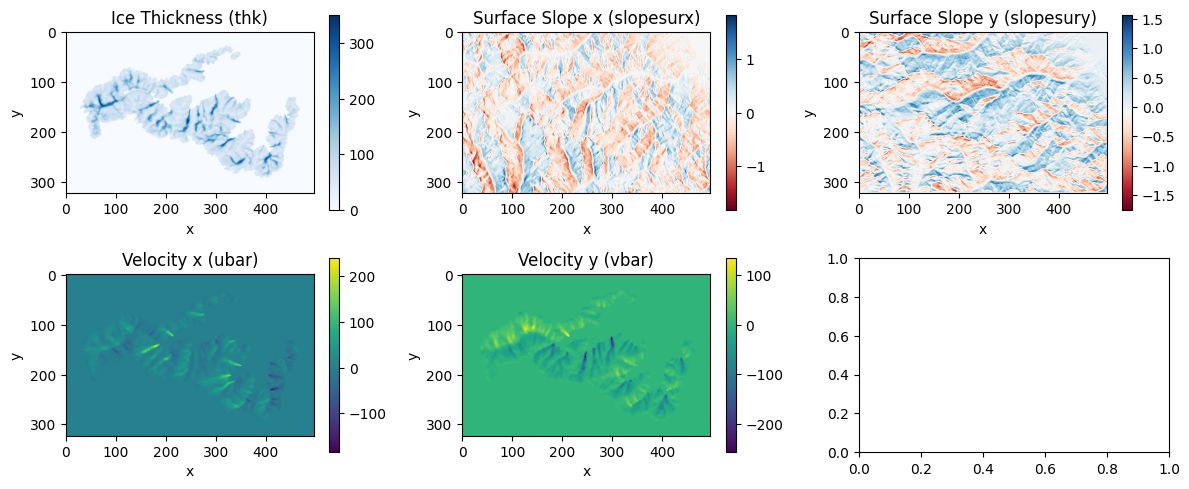

X_train shape: (270, 323, 497, 3)
y_train shape: (270, 323, 497, 2)
X_test shape: (33, 323, 497, 3)
y_test shape: (33, 323, 497, 2)


In [ ]:
# Retrieve the files from the cloud using Pooch.\n",
data_url = 'https://unils-my.sharepoint.com/:u:/g/personal/kejdi_lleshi_unil_ch/EZVN0nazQYFMoFkONuM4788BfSsSe3xjB-jSXYW9JibtHw?download=1'
hash = None
file = pooch.retrieve(data_url, known_hash=hash)

# Load and prepare the necessary dataset
merged_data= load_from_pooch(file)

# Visualize the I/O variables
inputs_scaled, outputs_scaled, scaling_factors = prepare_data(merged_data)
# Prepare the data for training
X_test_aug, X_train_aug, y_test_aug, y_train_aug=augment_data_for_training(inputs_scaled,outputs_scaled)


In [ ]:
if train_mode:

    # Train the model
    history = model.fit(X_train_aug, y_train_aug, batch_size=8, epochs=5, validation_data=(X_test_aug, y_test_aug))
    # Save the trained model to a file
    model.save_weights('model_weights.h5')


else :

    file_id = '1rwVaB8dTt175yVxDXp4dninfixsx2R9u'  # Replace with your file ID
    output_file = 'model_weights.h5'  # Name to save the file locally
    !gdown $file_id -O $output_file

    model.load_weights(output_file)




Downloading...
From: https://drive.google.com/uc?id=1rwVaB8dTt175yVxDXp4dninfixsx2R9u
To: /content/model_weights.h5
100% 142k/142k [00:00<00:00, 132MB/s]


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step


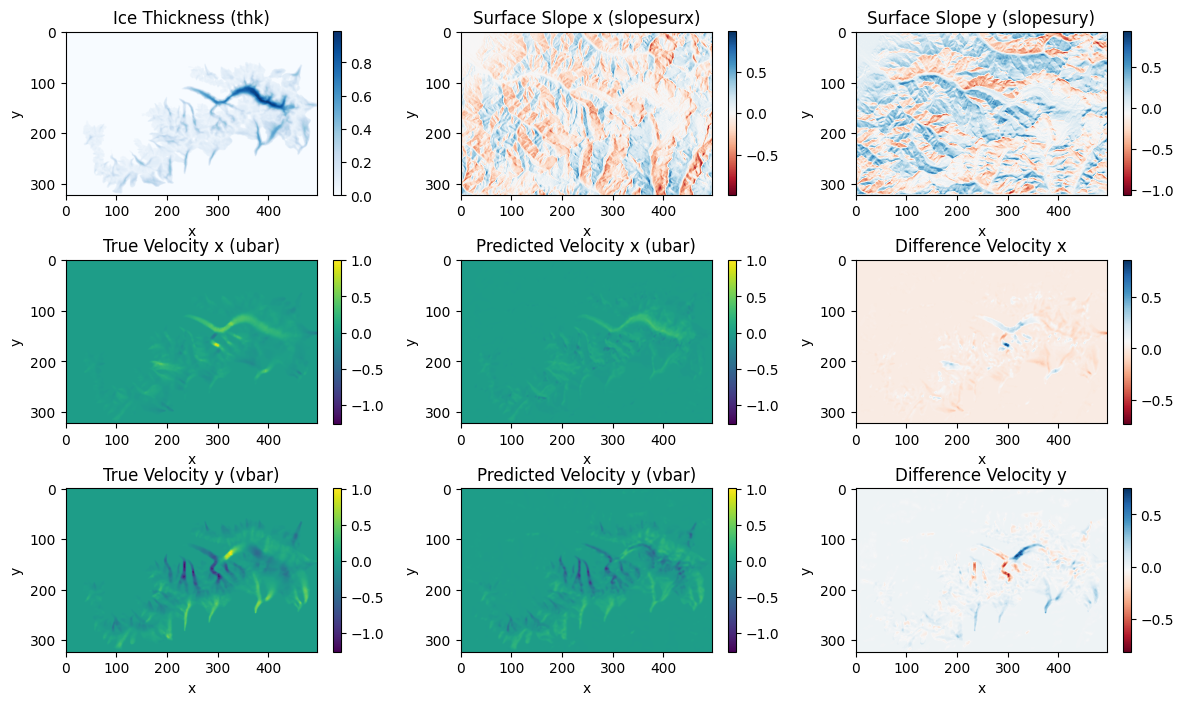

In [ ]:
# Visualise the performance of the trained model by making predictions

predicted_outputs = model.predict(X_test_aug)
# Separate predicted outputs into ubar and vbar components
pred_ubar = predicted_outputs[..., 0]  # First channel is ubar
pred_vbar = predicted_outputs[..., 1]  # Second channel is vbar
# Call the plot function for a specific time index, e.g., 0
time_idx = 2
plot_comparison(X_test_aug[..., 0], X_test_aug[..., 1], X_test_aug[..., 2], y_test_aug[..., 0], y_test_aug[..., 1], pred_ubar, pred_vbar, time_idx)

In [ ]:
#Plot the Learning curve

if train_mode:
    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(history.history['loss'], label='Training Loss')

    # Plot validation loss
    plt.plot(history.history['val_loss'], label='Validation Loss')

    # Add labels and legend
    plt.title('Learning Curve (Loss vs. Epochs)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.savefig("Lr.png")
    # Show plot
    plt.show()


#### Implementing the Hybrid Model

For the hybrid model, we will implement the mass conservation equation using a numerical scheme. The main difference from the first approach is how we calculate **u**(x, y). Instead of deriving it directly, we use the emulator trained earlier and plug it into the mass conservation equation to compute the flux.

To perform each iteration of the numerical scheme, we will need two helper functions: `compute_divflux()` and `compute_gradient_tf()`.

Remember that the velocity field **u** primarily depends on the slope and thickness of the glacier.

##### Helper functions for the hybrid model

In [ ]:
#@title Helper functions

@tf.function()
def compute_divflux(u, v, h, dx, dy):
    """
    Upwind computation of the divergence of the flux: d(u h)/dx + d(v h)/dy

    Parameters:
    - u: x-component of velocity (2D tensor).
    - v: y-component of velocity (2D tensor).
    - h: ice thickness (2D tensor).
    - dx: grid spacing in the x-direction (float).
    - dy: grid spacing in the y-direction (float).

    Returns:
    - divflux: divergence of flux (2D tensor).
    """
    # Compute u and v on the staggered grid
    u = tf.concat([u[:, 0:1], 0.5 * (u[:, :-1] + u[:, 1:]), u[:, -1:]], 1)  # shape (ny, nx+1)
    v = tf.concat([v[0:1, :], 0.5 * (v[:-1, :] + v[1:, :]), v[-1:, :]], 0)  # shape (ny+1, nx)

    # Extend h with constant value at the domain boundaries
    Hx = tf.pad(h, [[0, 0], [1, 1]], "CONSTANT")  # shape (ny, nx+2)
    Hy = tf.pad(h, [[1, 1], [0, 0]], "CONSTANT")  # shape (ny+2, nx)

    # Compute fluxes by selecting the upwind quantities
    Qx = u * tf.where(u > 0, Hx[:, :-1], Hx[:, 1:])  # shape (ny, nx+1)
    Qy = v * tf.where(v > 0, Hy[:-1, :], Hy[1:, :])  # shape (ny+1, nx)

    # Compute the divergence, final shape is (ny, nx)
    divflux = (Qx[:, 1:] - Qx[:, :-1]) / dx + (Qy[1:, :] - Qy[:-1, :]) / dy
    return divflux


@tf.function()
def compute_gradient_tf(s, dx, dy):
    """
    Compute spatial 2D gradient of a given field.

    Parameters:
    - s: surface elevation (2D tensor).
    - dx: grid spacing in the x-direction (float).
    - dy: grid spacing in the y-direction (float).

    Returns:
    - diffx: gradient in the x-direction (2D tensor).
    - diffy: gradient in the y-direction (2D tensor).
    """
    EX = tf.concat([1.5 * s[:, 0:1] - 0.5 * s[:, 1:2], 0.5 * s[:, :-1] + 0.5 * s[:, 1:], 1.5 * s[:, -1:] - 0.5 * s[:, -2:-1]], 1)
    diffx = (EX[:, 1:] - EX[:, :-1]) / dx

    EY = tf.concat([1.5 * s[0:1, :] - 0.5 * s[1:2, :], 0.5 * s[:-1, :] + 0.5 * s[1:, :], 1.5 * s[-1:, :] - 0.5 * s[-2:-1, :]], 0)
    diffy = (EY[1:, :] - EY[:-1, :]) / dy

    return diffx, diffy


def apply_boundary_condition(H_ice, boundary_width=5):
    """
    Apply boundary condition to the ice thickness field `H_ice`.
    The ice thickness will linearly decrease to zero starting from `boundary_width` pixels away from the boundary.

    Parameters:
    - H_ice: 2D numpy array representing ice thickness.
    - boundary_width: Number of pixels from the boundary where H_ice starts to decrease.

    Returns:
    - Modified H_ice with boundary condition applied.
    """
    ny, nx = H_ice.shape  # Get the dimensions of the ice thickness field

    # Create linear ramps
    ramp = np.linspace(1, 0, boundary_width)  # Ramp that linearly decreases from 1 to 0

    # Apply boundary condition to the left boundary
    H_ice[:, :boundary_width] *= ramp[::-1]  # Decrease from boundary to 5 pixels inwards

    # Apply boundary condition to the right boundary
    H_ice[:, -boundary_width:] *= ramp  # Decrease from 5 pixels inwards to the boundary

    # Apply boundary condition to the top boundary
    H_ice[:boundary_width, :] *= ramp[::-1, np.newaxis]  # Decrease vertically from top boundary

    # Apply boundary condition to the bottom boundary
    H_ice[-boundary_width:, :] *= ramp[:, np.newaxis]  # Decrease vertically to bottom boundary

    return H_ice


##### Run the hybrid model

In [ ]:
# Physical parameters
Lx = 49700    # Domain length in x (m)
Ly = 32300    # Domain length in y (m)
ttot = 700   # Time limit (yr)
grad_b = 0.001 # Mass balance gradient (no unit)
b_max = 0.5   # Maximum precip (m/yr)
Z_ELA = 3000  # Elevation of equilibrium line altitude (m)

# Initialization & load data

nout = 50  # Frequency of plotting
dtmax = 1   # maximum time step
cfl = 0.20
dx = 100
dy = 100  # Cell size in y
nx=int(Lx/dx)
ny=int(Ly/dy)
x = np.linspace(0, Lx, nx)  # x-coordinates
y = np.linspace(0, Ly, ny)  # y-coordinates

H_ice = np.zeros((ny, nx))  # Initial ice thickness
Z_surf = Z_topo + H_ice  # Initial ice surface
# Compute gradients of surface elevation (slopes)
slopsurfx, slopsurfy = compute_gradient_tf(Z_surf, dx, dx)
time = tf.cast(0.0, tf.float32)  # Initial time as float32
dt = tf.cast(dtmax, tf.float32)  # Cast dtmax to float32e
it = 0

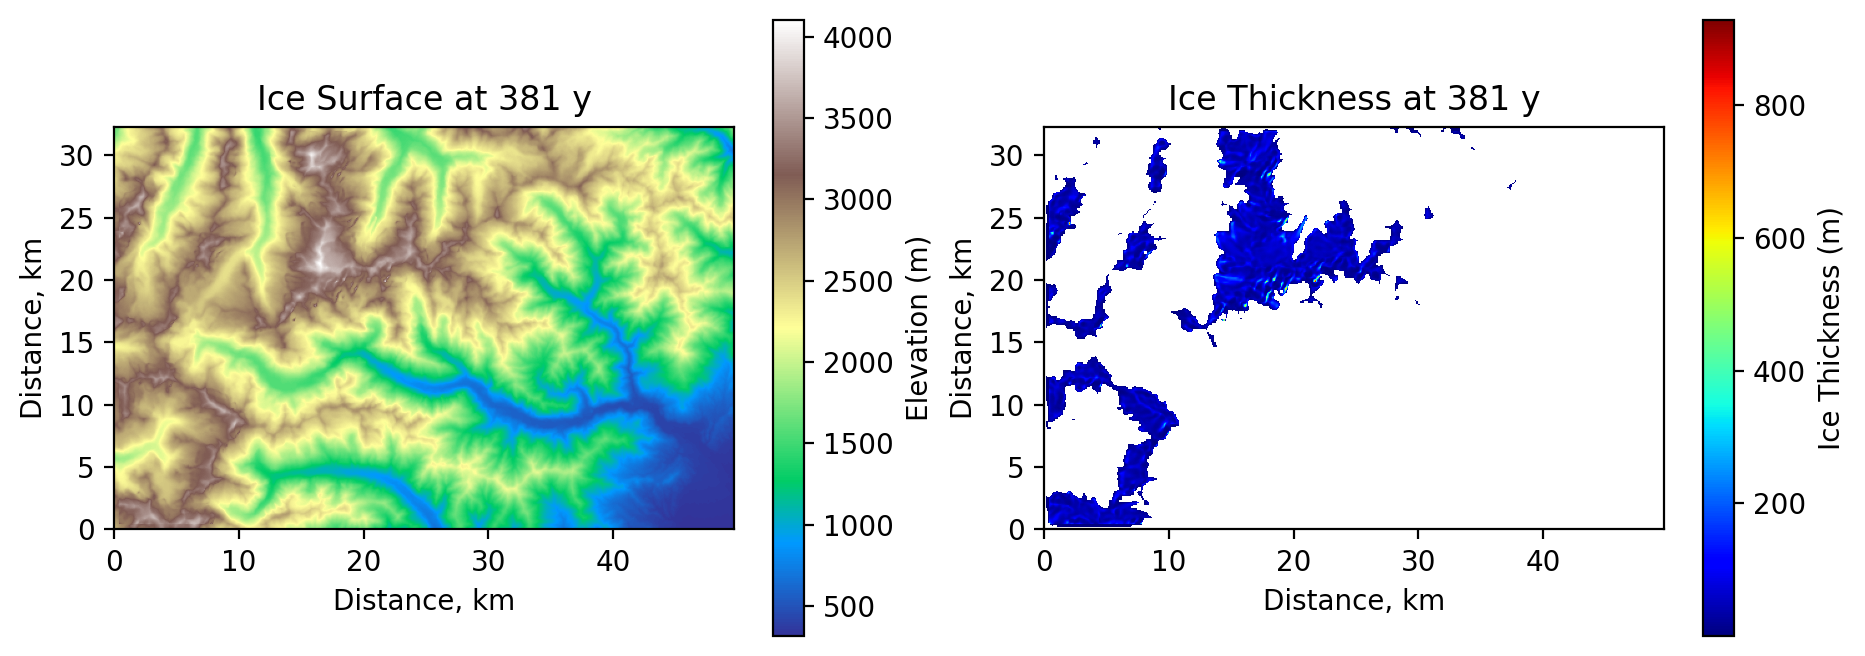

In [ ]:
# Ensure all arrays are float32
H_ice = tf.cast(H_ice, tf.float32)
slopsurfx = tf.cast(slopsurfx, tf.float32)
slopsurfy = tf.cast(slopsurfy, tf.float32)
Z_surf = tf.cast(Z_surf, tf.float32)
Z_topo = tf.cast(Z_topo, tf.float32)

#Fields need to be scaled

# Loop
while time < ttot:
    # Update time
    time += dt
    it += 1

    # Step 1: Scale the inputs with stored scaling factors
    H_ice_scaled = H_ice / scaling_factors["thk"]
    slopsurfx_scaled = slopsurfx / scaling_factors["slopsurfx"]
    slopsurfy_scaled = slopsurfy / scaling_factors["slopsurfy"]

    # Combine scaled inputs
    input_data_scaled = np.stack([H_ice_scaled, slopsurfx_scaled, slopsurfy_scaled], axis=-1)
    input_data_scaled = np.expand_dims(input_data_scaled, axis=0)  # Add batch dimension
    # Step 2: Use the trained model to predict ubar (x-velocity) and vbar (y-velocity)

    ubar_vbar_pred = model.predict(input_data_scaled, verbose=0)
    ubar = ubar_vbar_pred[0, :, :, 0] * scaling_factors["ubar"] # x-component of velocity (ubar)
    vbar = ubar_vbar_pred[0, :, :, 1] * scaling_factors["vbar"] # y-component of velocity (vbar)

    # Step 3: Compute maximum velocity for CFL condition
    vel_max = max(
        tf.math.reduce_max(tf.math.abs(ubar)),
        tf.math.reduce_max(tf.math.abs(vbar)),
    ).numpy()

    # Step 4: Compute time step (CFL condition)
    dt = tf.cast(tf.minimum(cfl * dx / vel_max, dtmax), tf.float32)

    # Step 5: Update rule divergence of the flux: Compute the change in thickness (dH/dt)
    # Hint: Use Helper function
    dHdt = - compute_divflux(ubar, vbar, H_ice, dx, dy)

    # Update ice thickness (ensure no negative values)
    H_ice += dt * dHdt

    # Define the SMB (Surface Mass Balance)
    b = tf.minimum(grad_b * (Z_surf - Z_ELA), b_max)

    # Update rule (mass balance)
    H_ice += dt * b

    # Update rule (positive thickness)
    H_ice = np.maximum(H_ice, 0)

    # Apply the boundary condition before the next iteration
    H_ice = apply_boundary_condition(H_ice)

    # Update surface topography
    Z_surf = Z_topo + H_ice

    # Compute gradients of surface elevation (slopes)
    slopsurfx, slopsurfy = compute_gradient_tf(Z_surf, dx, dx)

    # Update ELA after 500 years
    if time > 500:
        Z_ELA = 2700

   # Display
    if it % nout == 0:
        clear_output(wait=True)  # Clear the previous output in the notebook

        plt.figure(2, figsize=(11, 4), dpi=200)

        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf, extent=[0, Lx/1000, 0, Ly/1000], cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')

        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice > 0, H_ice, np.nan), extent=[0, Lx/1000, 0, Ly/1000], cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')

        # Show the plot
        plt.show()

⚡ *Note how much faster the hybrid model is?*  

**Q: What are some disadvantages of hybrid models?**  
* <i>Boundary conditions are difficult to implement.</i>  
* <i>The model is only as good as the data it is trained on.</i>  


**Q: What are some other fields where we can use Hybrid Models?**  
* <i> 1.</i>  
* <i> 2.</i>  